# Battery Drain Analysis

This notebook analyzes the battery logs collected from an Android device using `adb`.

We will use the custom `parsing.py` module to process the raw log files and then visualize the key findings, such as:

*   Battery level decrease over time.
*   Top applications and components consuming power.

In [1]:
import pandas as pd
import parsing
import warnings
import re
import os

# The 'seaborn-v0_8-grid' style can sometimes raise a UserWarning with matplotlib,
# which we can safely ignore for this analysis.
warnings.filterwarnings('ignore', category=UserWarning, module='seaborn')

# Configure pandas for better display in the notebook
pd.set_option('display.max_rows', 100)

print("Setup complete. Libraries and 'parsing.py' module imported.")

Setup complete. Libraries and 'parsing.py' module imported.


## Load and Process All Log Data

Here, we call the main processing function from our `parsing.py` script. It automatically finds all the log folders, parses the relevant files, and aggregates the data into two convenient pandas DataFrames.

In [2]:
print("Processing all log files from the 'logs' directory...")
battery_df, power_df, longwake_df = parsing.process_all_logs()
print("Data processing complete.")
parsing.display_device_info()

if not battery_df.empty:
    print("\n--- Sample of Battery Level Data ---")
    display(battery_df.head())

else:
    print("\nCould not load data. Ensure the 'logs' directory exists and contains valid log files.")

Processing all log files from the 'logs' directory...
Data processing complete.
--- Device Information (from latest log) ---
  Log Source: 2025-09-01_20-00
  Phone Model: IV2201
  Android OS Version: 13
  Estimated Battery Health: 63.3%

--- Sample of Battery Level Data ---


,level
timestamp,
2025-09-01 17:47:00,28
2025-09-01 18:27:00,35
2025-09-01 19:22:00,44
2025-09-01 20:00:00,50


## 1. Battery Level Over Time

The first step is to visualize the most direct metric: the battery percentage over the data collection period. This gives us a high-level overview of the discharge rate.

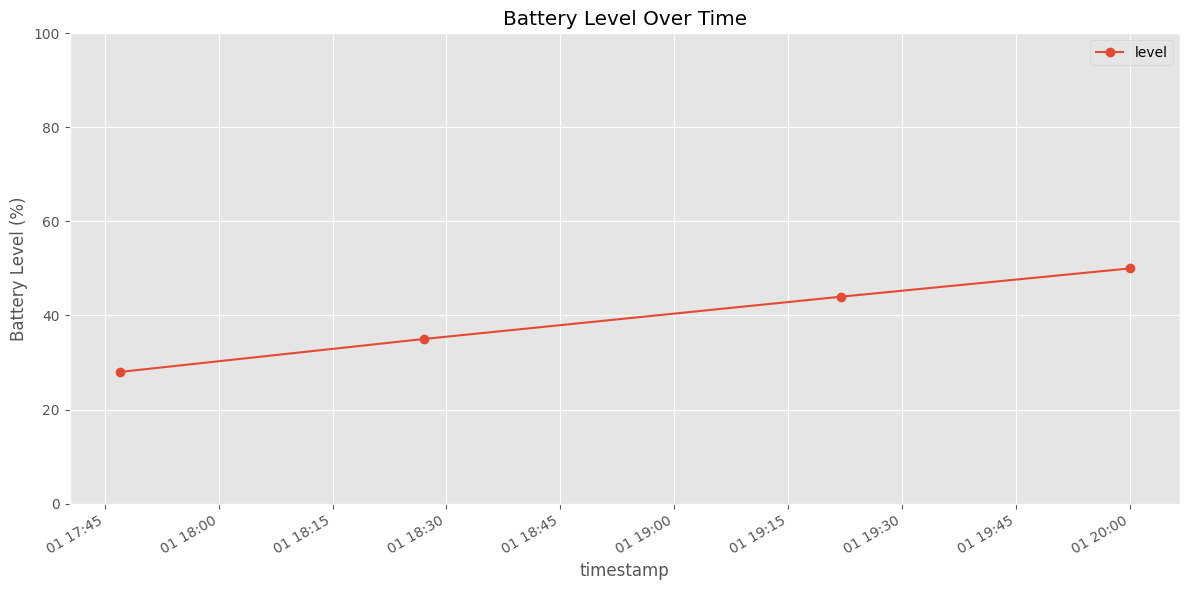

In [3]:
if not battery_df.empty:
    parsing.plot_battery_level(battery_df)
else:
    print("No battery level data was found to plot.")

## 2. Top Power Consumers

Next, we'll identify which specific applications and hardware components used the most power (measured in mAh) across the entire logging session. This is the most critical chart for identifying problematic apps.

The `batterystats` service provides an estimated power draw for each component. We sum these estimates from all the log files to get a total consumption figure.

c:\Users\user\Desktop\battery_proj\parsing.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='power_mah', y='name', data=top_consumers, ax=ax, palette='viridis')


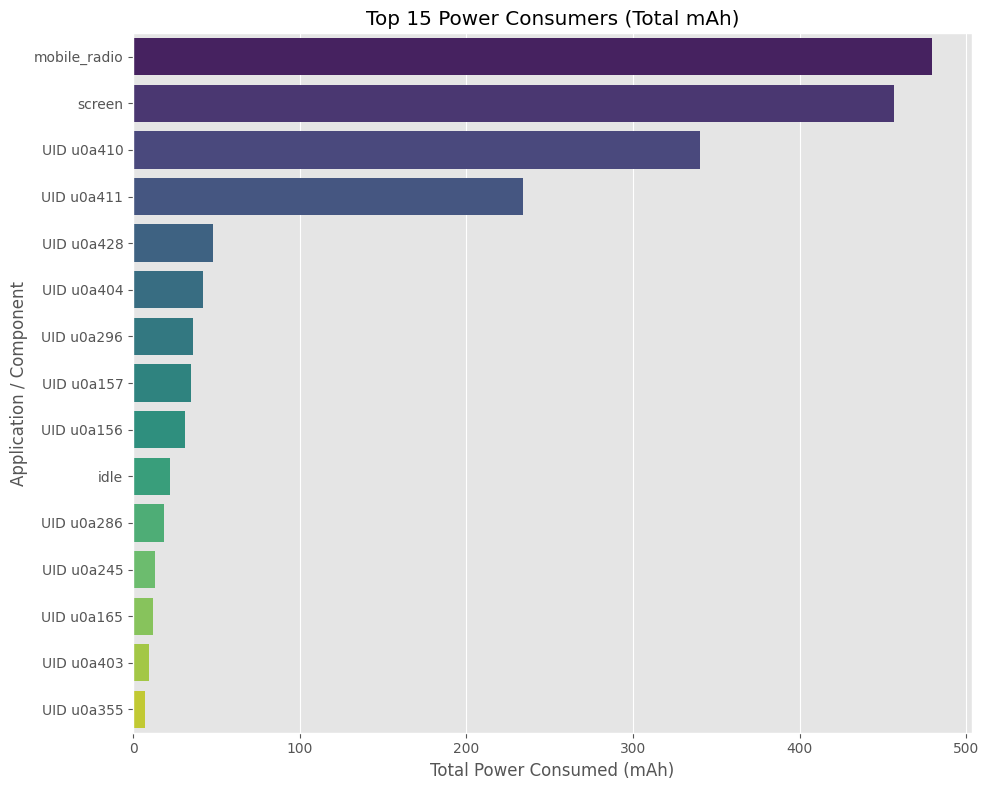

In [4]:
if not power_df.empty:
    # We can adjust the number of items to show in the plot by changing top_n
    parsing.plot_top_consumers(power_df, top_n=15)
else:
    print("No power consumption data was found to plot.")

## 3. Wakelock Analysis

Wakelocks are mechanisms that prevent the device from entering a deep sleep state. They are a common source of battery drain, especially if held for long periods. Here, we identify which applications or services are holding wakelocks the longest.

--- Top 15 Longwakes by Total Duration (in seconds) ---


,uid,tag,duration_s
0,u0a410,AudioMix,4158.493
1,u0a286,*job*/com.snapchat.android/androidx.work.impl....,3197.661
2,u0a411,AudioMix,1995.066
3,u0a411,ExoPlayer:WakeLockManager,1467.510
4,u0a428,AudioMix,577.776
5,u0a404,AudioMix,538.646
6,u0a156,AudioMix,99.459
7,u0a296,*job*/com.android.contacts/com.whatsapp/WhatsA...,60.613
8,u0a296,*sync*/com.android.contacts/com.whatsapp/WhatsApp,60.468
9,1000,*job*/android/com.android.server.pm.Background...,30.397


c:\Users\user\Desktop\battery_proj\parsing.py:205: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='duration_s', y='label', data=top_items, ax=ax, palette='plasma')


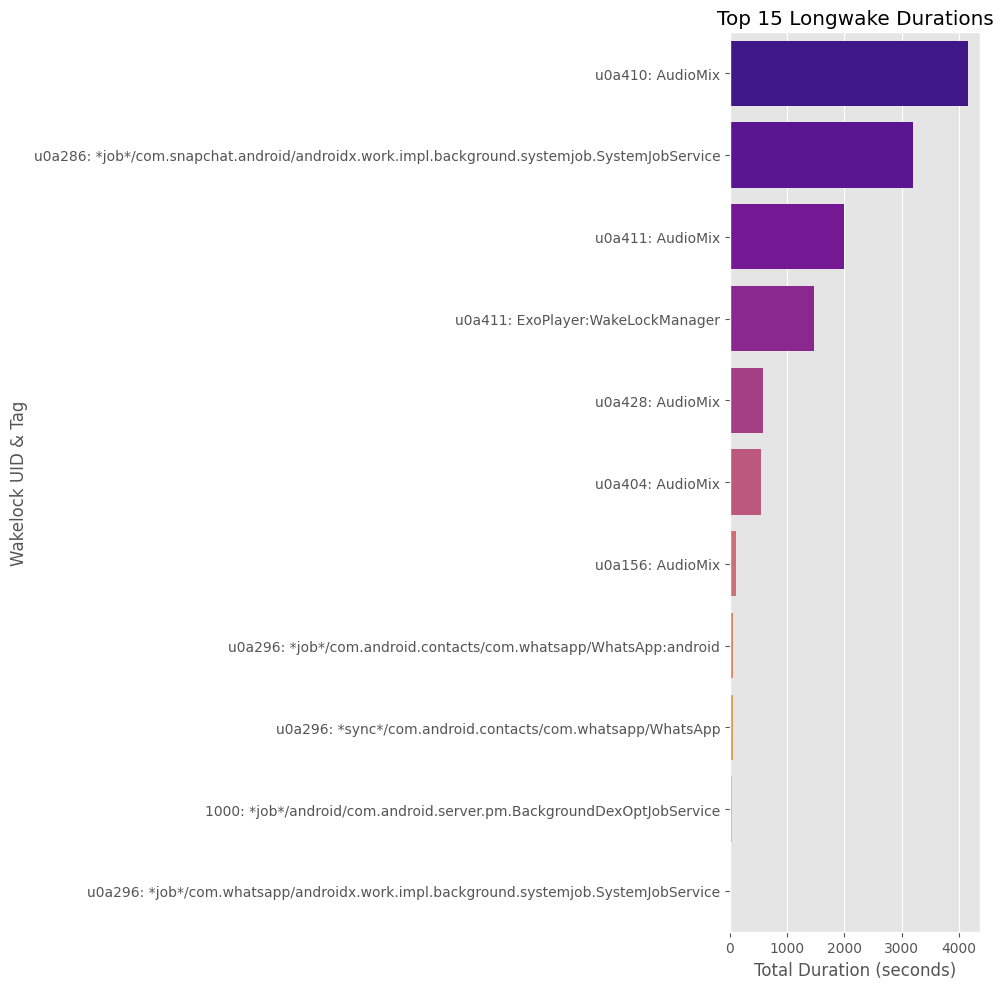

In [5]:
# Add this to a new cell for wakelock analysis
if not longwake_df.empty:
    print("--- Top 15 Longwakes by Total Duration (in seconds) ---")
    display(longwake_df.head(15))
    
    # Use the new plotting function for longwakes
    parsing.plot_top_longwakes(longwake_df, top_n=15)
else:
    print("No significant longwake data was found to analyze.")


## 4. Combined Analysis: Identifying Top Offenders

Now we'll correlate the two main sources of battery drain: direct power consumption (in mAh) and wakelocks (in seconds). An application that appears high on both lists is likely a primary target for optimization.

We will merge our two dataframes to see this relationship clearly.

In [6]:
# First, we need to clean up the app names from the wakelock data.
# The UID (e.g., u0a286) isn't as readable as the package name.
# We'll extract the package name from the 'tag' column.

def get_package_name_from_tag(tag):
    # This regex finds things that look like package names (e.g., com.snapchat.android)
    match = re.search(r'([a-zA-Z0-9_]+\\.[a-zA-Z0-9_\\.]+)', tag)
    return match.group(1) if match else 'System/Other'

if not longwake_df.empty:
    longwake_df['name'] = longwake_df['tag'].apply(get_package_name_from_tag)
    # Now, we sum up wakelock durations by the cleaned package name
    app_wakelocks = longwake_df.groupby('name')['duration_s'].sum().reset_index()

    # Merge the power consumption data with the wakelock data
    if not power_df.empty:
        # We use an 'outer' merge to keep all apps from both lists
        combined_df = pd.merge(power_df, app_wakelocks, on='name', how='outer').fillna(0)
        
        # We can create a simple 'score' to rank the worst offenders
        # This is a basic approach, you can tune the weighting
        combined_df['drain_score'] = (combined_df['power_mah'] * 0.7) + (combined_df['duration_s'] * 0.3)
        
        # Sort by the new score
        combined_df = combined_df.sort_values(by='drain_score', ascending=False)

        print("--- Combined Analysis: Top Battery Offenders ---")
        display(combined_df.head(15))
    else:
        print("Power consumption data is empty, cannot create combined analysis.")
else:
    print("Wakelock data is empty, cannot create combined analysis.")


--- Combined Analysis: Top Battery Offenders ---


,name,power_mah,duration_s,drain_score
0,System/Other,0.000000,12186.395,3655.918500
137,mobile_radio,479.189800,0.000,335.432860
139,screen,456.248500,0.000,319.373950
86,UID u0a410,340.000000,0.000,238.000000
87,UID u0a411,234.000004,0.000,163.800003
88,UID u0a428,48.200000,0.000,33.740000
85,UID u0a404,41.900000,0.000,29.330000
66,UID u0a296,36.000000,0.000,25.200000
26,UID u0a157,35.000000,0.000,24.500000
25,UID u0a156,31.300000,0.000,21.910000


In [7]:
from getpass import getpass

# Run this cell, and it will prompt you to enter your key securely
api_key = getpass('Enter your Gemini API Key: ')
os.environ['GEMINI_API_KEY'] = api_key

print("GEMINI_API_KEY has been set for this notebook session.")

GEMINI_API_KEY has been set for this notebook session.


In [8]:
from google import genai
from IPython.display import display, Markdown

# 2. Set up the Gemini API Client
# IMPORTANT: Before running this, ensure your API key is set as an environment variable.
# In your terminal, you can do: set GEMINI_API_KEY=YOUR_API_KEY
# Then restart your Jupyter kernel for the change to take effect.
if 'GEMINI_API_KEY' not in os.environ:
    print("ERROR: Please set the GEMINI_API_KEY environment variable before running this cell.")
else:
    client = genai.Client()

    # 3. Prepare the data and prompt
    # Select the top 10 offenders to send to the model
    top_offenders_df = combined_df.head(10)
    offenders_csv = top_offenders_df.to_csv(index=False)

    prompt = f"""You are an expert Android battery life analyst.

    I have collected battery statistics from my Android device. The following CSV data contains the top battery-draining processes, including their direct power consumption in mAh (`power_mah`) and the total time they held a wakelock in seconds (`duration_s`). A high `drain_score` indicates a worse offender.

    **Data:**
    ```csv
    {offenders_csv}
    ```

    Please provide a detailed analysis and report with the following sections:

    1.  **Top Offenders Analysis:** Briefly describe the top 3-5 processes from the list. What is their likely function on the device?

    2.  **System vs. User Apps:** Differentiate between which of these are critical system processes and which are user-installed applications.

    3.  **Potential Reasons for Drain:** For the top offenders, explain the most likely reasons for their high battery consumption based on the data (e.g., high `power_mah` suggests active use, while high `duration_s` suggests background activity or poor sleep behavior).

    4.  **Actionable Recommendations:** Provide a clear, bulleted list of potential solutions or steps a user can take to improve their battery life based on this specific data.
    """

    # 4. Generate the report
    print("Generating battery analysis report with Gemini...")
    try:
        response = client.models.generate_content(
            model='gemini-2.5-flash',
            contents=prompt
        )
        
        print("Report generation complete.")
        display(Markdown(response.text))

    except Exception as e:
        print(f"\\nAn error occurred: {e}")
        print("Please ensure the 'google-genai' library is installed (`pip install google-genai`) and your API key is correct.")

Generating battery analysis report with Gemini...
Report generation complete.


As an expert Android battery life analyst, I've reviewed your provided data to diagnose the primary culprits behind your device's power consumption. The `drain_score` effectively highlights the most impactful offenders, considering both direct power consumption (`power_mah`) and wake-lock duration (`duration_s`).

Here's a detailed analysis and report:

---

### Android Battery Life Analysis Report

**Data Overview:**
The data indicates several significant battery drains, with "System/Other" being an overwhelming top offender due to prolonged wakelock activity, followed by "mobile_radio" and "screen" due to active power consumption. Several user applications (identified by their UIDs) are also contributing notably.

#### 1. Top Offenders Analysis

Based on the `drain_score`, the top 5 offenders are:

1.  **System/Other (Drain Score: 3655.92)**
    *   **Likely Function:** This is a catch-all category that represents various low-level system processes, kernel activity, Android OS services, and unidentified wakelocks. Its high `duration_s` (over 3.3 hours) with zero `power_mah` is a classic indicator of a "wakelock" – something preventing your device from entering deep sleep, even if it's not directly consuming power itself.

2.  **mobile_radio (Drain Score: 335.43)**
    *   **Likely Function:** This refers to the cellular modem and its associated services. It's responsible for all aspects of your mobile connectivity, including calls, SMS, and mobile data usage (4G/5G). Its significant `power_mah` indicates active and frequent use of cellular communication.

3.  **screen (Drain Score: 319.37)**
    *   **Likely Function:** This represents the power consumed by your device's display. It directly correlates with how long your screen is on and at what brightness level. High `power_mah` here means the screen has been on for a substantial amount of time.

4.  **UID u0a410 (Drain Score: 238.00)**
    *   **Likely Function:** This is a User ID (UID) assigned to a specific application on your device. UIDs starting with `u0a` typically belong to user-installed applications or non-critical system applications. Its high `power_mah` suggests this app is actively performing tasks, potentially in the foreground or background.

5.  **UID u0a411 (Drain Score: 163.80)**
    *   **Likely Function:** Similar to `u0a410`, this is another user-specific application. Its significant `power_mah` indicates active power consumption, likely due to its operations, whether in active use or background processes.

#### 2. System vs. User Apps

*   **Critical System Processes:**
    *   **System/Other:** This is a core part of the Android operating system and kernel.
    *   **mobile_radio:** Essential for cellular connectivity.
    *   **screen:** Essential for the device's display.
    These are fundamental components necessary for your phone to function.

*   **User-Installed Applications (or Non-Critical System Apps):**
    *   **UID u0a410:** Very likely a user-installed application (e.g., social media, streaming app, game, utility) or a less critical vendor-specific system app.
    *   **UID u0a411:** Also very likely a user-installed application or a non-essential system app.
    *   All other `UID u0aXXX` entries (`u0a428`, `u0a404`, `u0a296`, `u0a157`, `u0a156`) fall into this category. To identify these apps precisely, you would need to cross-reference these UIDs with package names using tools like `adb shell dumpsys batterystats` or third-party battery monitoring apps.

#### 3. Potential Reasons for Drain

*   **System/Other:**
    *   **Reason:** The primary reason is **excessive wakelocks**. The device is being prevented from entering its lowest power state (deep sleep) for over 3 hours, even if `System/Other` itself isn't directly drawing power. This "awake" state keeps the CPU and other components running at higher frequencies and power levels than necessary. Common causes include buggy applications, misbehaving background services, kernel issues, or even poorly optimized drivers.

*   **mobile_radio:**
    *   **Reason:** The high `power_mah` points to **heavy or inefficient use of your cellular connection**.
        *   **Poor Signal Strength:** If your device is frequently in areas with weak cellular reception, the modem has to work harder and transmit at higher power to maintain a stable connection, leading to significant battery drain.
        *   **High Mobile Data Usage:** Extensive use of mobile data for streaming, downloads, gaming, or apps with constant background syncing will consume a lot of power.
        *   **Frequent Network Scans:** Some apps or system services might cause the modem to frequently scan for network availability.

*   **screen:**
    *   **Reason:** The high `power_mah` indicates **extended screen-on time and/or high brightness levels**. This is a straightforward drain: the more you use your device with the screen on, especially at higher brightness, the more power it will consume.

*   **UID u0a410 & UID u0a411:**
    *   **Reason:** Their significant `power_mah` (with zero `duration_s` in this specific snapshot) indicates **active processing or tasks** by these applications. This could be due to:
        *   **Foreground Usage:** If these are apps you actively use frequently (e.g., games, social media, video editing).
        *   **Background Activity:** They might be running intensive tasks in the background, such as syncing large amounts of data, performing location tracking, constantly refreshing content, or processing notifications, even when the app isn't open on screen.
        *   **Inefficient Coding/Bugs:** The apps might not be optimized for battery efficiency, leading to higher-than-necessary power draw for their functions.

#### 4. Actionable Recommendations

Based on this specific data, here's a clear, bulleted list of steps you can take to improve your battery life:

*   **Investigate and Resolve "System/Other" Wakelocks:**
    *   **Use a Wakelock Detector App:** Install an app like BetterBatteryStats or Wakelock Detector (requires ADB/root setup for full functionality) to get a more granular breakdown of what specific wakelocks are contributing to "System/Other." This is crucial for identifying the underlying app or service.
    *   **Reboot Your Device:** A simple restart can often clear temporary software glitches that cause persistent wakelocks.
    *   **Review Recent App Installs/Updates:** If this drain is new, consider what applications you installed or updated recently. A rogue app is a common cause.
    *   **Update System Software:** Ensure your Android OS and all system apps are up-to-date, as bug fixes often address power consumption issues.
    *   **Check Accessibility Services:** Some accessibility services can cause wakelocks. Review which ones are active.

*   **Optimize Mobile Radio Usage:**
    *   **Improve Signal Environment:** Try to use your phone in areas with good cellular reception. If you're consistently in a weak signal area, use Wi-Fi whenever possible.
    *   **Limit Background Mobile Data:** Go to **Settings > Apps > [App Name] > Mobile data & Wi-Fi** and disable "Background data" or "Unrestricted data usage" for apps that don't need constant internet access when not in use.
    *   **Disable Mobile Data When on Wi-Fi:** If you're primarily on Wi-Fi, consider turning off mobile data when it's not needed.
    *   **Enable Wi-Fi Calling (If Supported):** If your carrier supports it, Wi-Fi calling can reduce mobile radio drain when on a strong Wi-Fi network.

*   **Reduce Screen-On Time:**
    *   **Lower Brightness:** Manually reduce your screen brightness to the lowest comfortable level, or use adaptive brightness and adjust its sensitivity if it tends to set the screen too bright.
    *   **Shorter Screen Timeout:** Set your screen to turn off faster when inactive (e.g., 15-30 seconds) via **Settings > Display > Screen timeout**.
    *   **Use Dark Mode/Theme:** If your device has an OLED screen, using dark mode can significantly save battery by turning off black pixels.

*   **Manage Top User Applications (UID u0a410, u0a411, etc.):**
    *   **Identify the Apps:** Use an app like BetterBatteryStats or GSam Battery Monitor, or the `adb shell dumpsys batterystats` command, to map these UIDs to their actual application names.
    *   **Review App Usage:** For the identified apps, assess if their high power consumption is justified by your active usage.
    *   **Restrict Background Activity:** For apps not critical for instant notifications, restrict their background activity through **Settings > Apps > [App Name] > Battery**. Choose "Restricted" or "Optimized" to limit what they can do when not actively in use.
    *   **Disable Unnecessary Notifications:** If an app is excessively chatty and constantly waking your device for non-essential notifications, disable them through app settings or Android's notification settings.
    *   **Keep Apps Updated:** Ensure these apps are on their latest versions, as developers often include battery optimizations.
    *   **Consider Alternatives or Uninstall:** If an identified app continues to be a major drain and its function isn't essential or can be replaced by a more efficient alternative, consider uninstalling it.

By systematically addressing these specific areas, you should observe a noticeable improvement in your device's overall battery longevity.